# Feature analysis



In [22]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
df = pd.read_csv('../final_merge.csv')

Let's put the dataframe in a good form for the rest of the analysis.

First, we remove all useless column, or the one we don't want to describe a song.

In [24]:
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [25]:
df_stage1 = df.drop(['Unnamed: 0', 'artist_latitude', 'artist_location', 'artist_id', 'artist_longitude', 'song_id', 'track_id', 'artist_hotttnesss', 'mode_x', 'mode_y'], axis=1)

We will need a one hot encoded matrix for genre for future analysis. We need all the genres in a first time.

In [26]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
print(genres)
print(len(genres))

{nan, 'Reggae', nan, 'Folk', 'Pop', 'Rock', 'Punk', 'International', 'World', 'Pop_Rock', 'Electronic', 'Jazz', 'Latin', 'Rap', 'New Age', 'RnB', 'Vocal', 'Metal', 'Country', 'Blues'}
20


We have 17 different genres (nan are unkownn and international is the same as world). To do a meaningful analysis of the genre analysis over the year a minimum amount of songs of the analyzed type must be in the dataset. In the following cells we first replace the nan and replace International by World. 

In [27]:
df_stage1[genres_cols] = df_stage1[genres_cols].fillna('Unknown')
df_stage1[genres_cols] = df_stage1[genres_cols].replace('International', 'World')

Let's just check that we have the wanting form

In [28]:
df_stage1[genres_cols].head()

,genre1_cd2c,genre2_cd2c,genre1_cd2,genre2_cd2,genre1_cd1,genre2_cd1
0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,Unknown,Unknown,Electronic,Rap,Electronic,Rap
3,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


For the moment we have 6 columns for the genres, we would like to see if we can summarize these columns in one or two columns.
First we perform a pivot and count the number of different values there are in each column. 

In [29]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
    df_stage1[col_name] = df_stage1[col_name].astype(str)
print(genres)
print(len(genres))

{'Reggae', 'Folk', 'Pop', 'Rock', 'Punk', 'World', 'Pop_Rock', 'Electronic', 'Unknown', 'Jazz', 'Latin', 'Rap', 'New Age', 'RnB', 'Vocal', 'Metal', 'Country', 'Blues'}
18


In [30]:
for genre in list(genres):
    df_stage1[genre] = 0
    for col_name in genres_cols:
        df_stage1.loc[df_stage1[col_name] == genre, genre] = 1
df_stage1.drop(columns=['Unknown'], axis=1, inplace=True)
genres.remove('Unknown')

Let's make sure we have a hot encoded matrix at the end now

In [69]:
df_stage2 = df_stage1.drop(genres_cols, axis=1).copy()
df_stage2.head()

,song_hotttnesss,loudness_x,tempo_x,key_x,duration,year,danceability,energy,key_y,loudness_y,...,Electronic,Jazz,Latin,Rap,New Age,RnB,Vocal,Metal,Country,Blues
0,0.542899,-4.829,87.002,10,252.05506,2003,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,0.299877,-10.555,150.778,9,156.55138,1995,0.489,0.583,9.0,-10.303,...,0,0,0,0,0,0,0,0,0,0
2,0.617871,-2.060,177.768,7,138.97098,2006,0.662,0.823,4.0,-1.711,...,1,0,0,1,0,0,0,0,0,0
3,NaN,-4.654,87.433,7,145.05751,2003,0.690,0.619,7.0,-4.302,...,0,0,0,0,0,0,0,0,0,0
4,NaN,-7.806,140.035,5,514.29832,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Now that the matrix is ready, let's see if we can spot something from a simple correlation between the data, especially between song_hotttnesss and the rest of the features.

In [94]:
def plot_corr(df, output_file_name):
    '''
        Plot the correlation matrix of a dataframe
        The plot will be triangular with negative values blue and positive values red
        Code taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        :param df: The dataframe
        :type df: DataFrame
    '''
    sns.set(style="white", font_scale=1.5)

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))
    f.suptitle("Correlation heatmap")

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    snsplot = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    snsplot.figure.savefig(output_file_name)


A final remark about song year. Most of them are in fact 0:

In [162]:
df_stage2[df_stage2.year == 0].year.count()

487428

Let's remove them for the correlation.

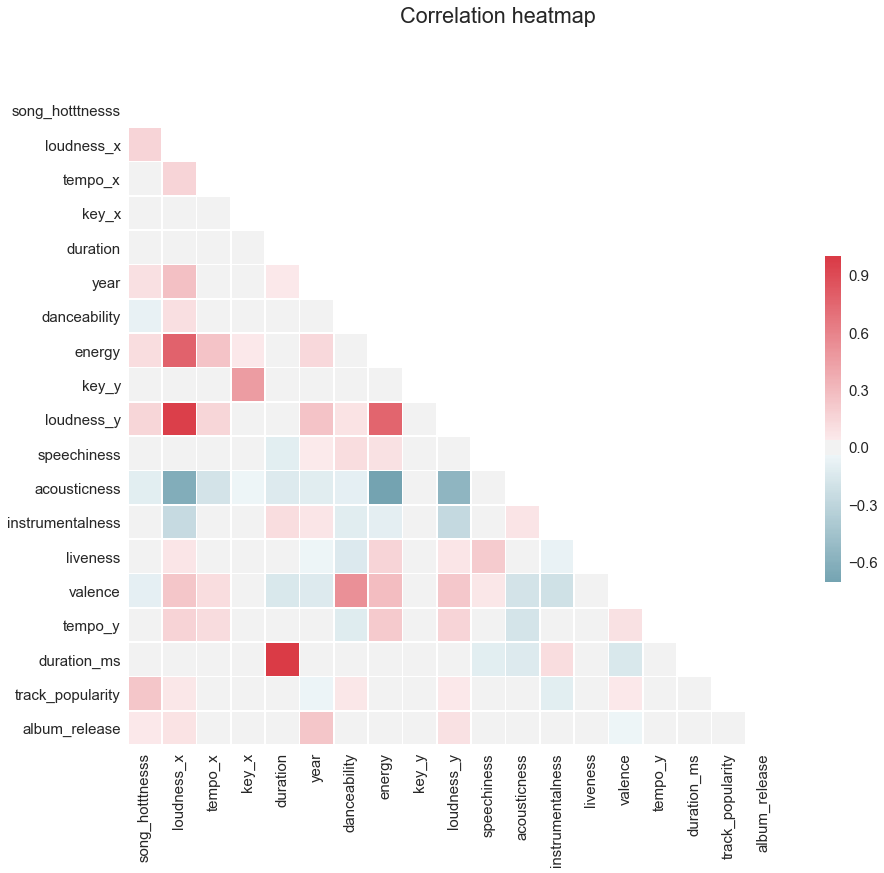

In [164]:

plot_corr(df_stage2[df_stage2.year != 0][df_stage2.columns[0:-17]], "../datastory/figures/correlationComplete.png")

What do we see here ?

1) the value between spotify and MSD on the duration is highly correlated, same for loudness and key, so let's keep the original one 

2) track_popularity and song_hotttnesss is moderately correlated, thus we will keep the song_hotttnesss

3) year of MSD and album release from spotify is absolutely not correlated, so let's keep the one from MSD again

4) no feature looks highly, even moderately, correlated to the song_hotttnesss

Let's drop the useless columns again

In [169]:
df_stage3 = df_stage2.drop(['album_release', 'track_popularity', 'duration_ms', 'key_y', 'loudness_y'], axis=1)
df_stage3.rename(columns={'key_x': 'key', 'loudness_x': 'loudness'}, inplace=True)

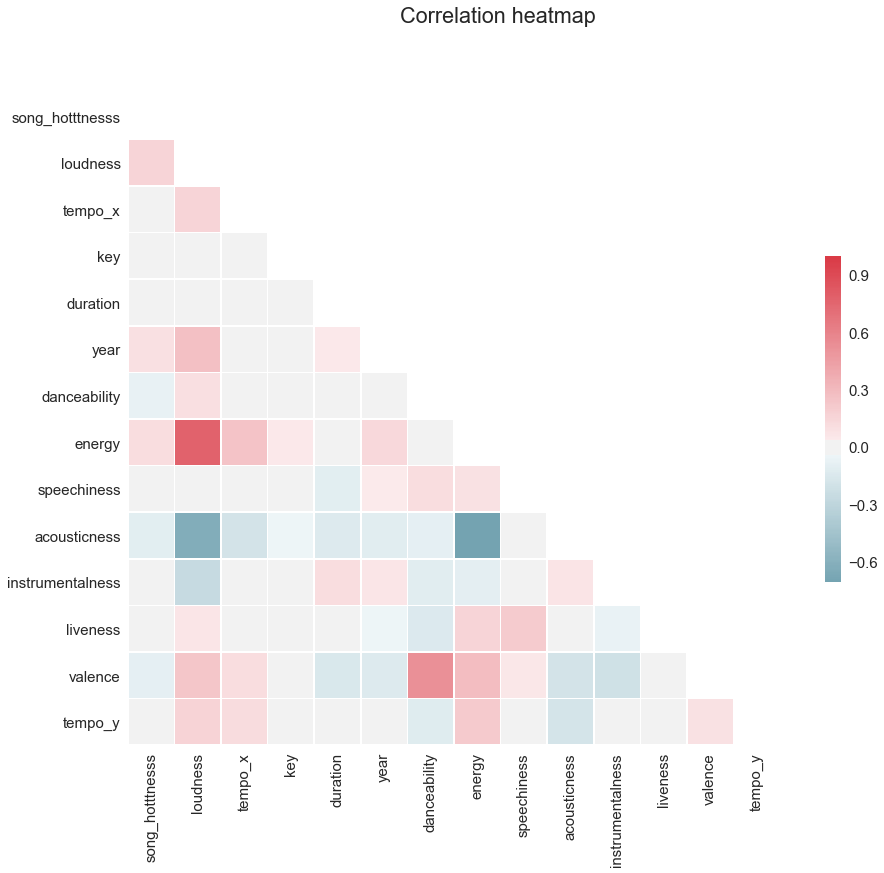

In [170]:
plot_corr(df_stage3[df_stage3.year != 0][df_stage3.columns[0:-17]], "../datastory/figures/correlationReduce.png")

And let's do the same thing for genre only.

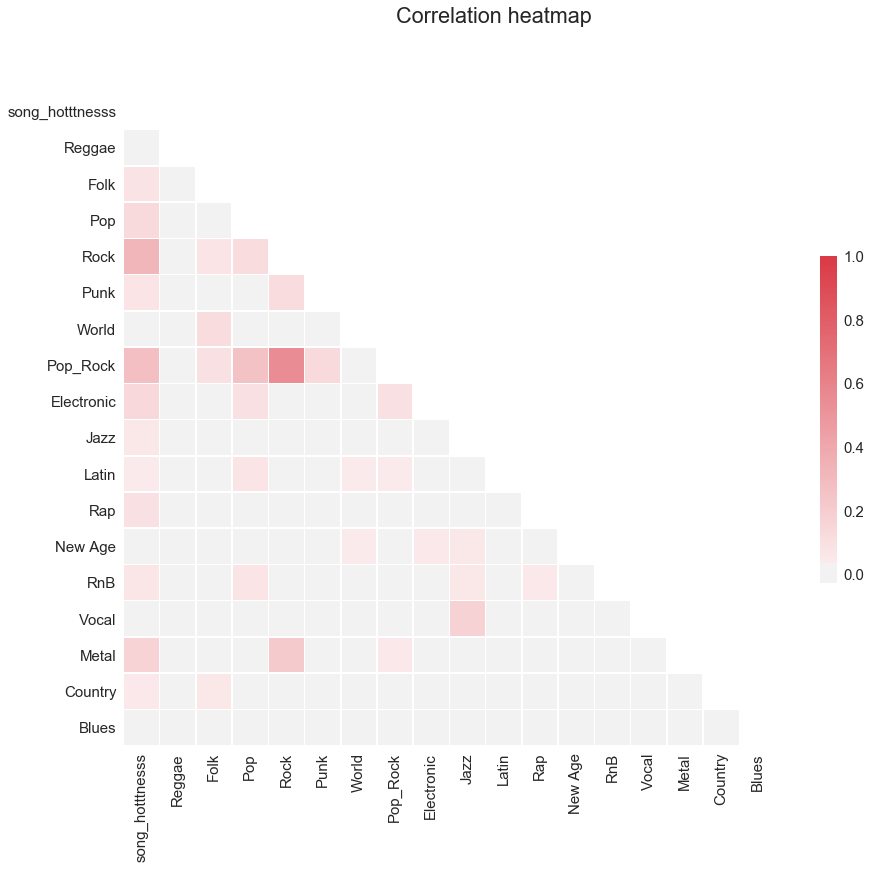

In [171]:
plot_corr(pd.concat([df_stage3[['song_hotttnesss']],df_stage3[df_stage3.columns[-17:]]], axis=1), "../datastory/figures/correlationGenre.png")

We want know to check if we can train a regressor and export the features importance. Here we use an RandomForest like in HW4, but a regressor one this time.

In [76]:
from sklearn.externals import joblib
COMPUTE = True

if COMPUTE:
    
    regressor = RandomForestRegressor(n_jobs=-1, n_estimators = 400, verbose=True)

    df_stage4 = df_stage3.copy().dropna(subset=['song_hotttnesss'])

    train_set = df_stage4.drop(['song_hotttnesss'], axis=1)
    train_set = train_set.fillna(-1)

    train_label = df_stage4.song_hotttnesss

    regressor.fit(train_set, train_label)
    
    joblib.dump(regressor, 'completeRegressor.pkl')
    
else:
    
    regressor = joblib.load('completeRegressor.pkl') 

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 29.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

Let's check the importance per feature, in order to extract some useful insights. 

Note that we sum the importance of each genre to see what they mean for the whole random forest.

In [78]:
sum = 0.0
for a, b in sorted(zip(regressor.feature_importances_, train_set.columns), reverse=True):
    print(a, " : ", b)
    if b in genres:
        sum += a
        
sum

0.188469196095  :  year
0.13877758397  :  loudness_x
0.135765244037  :  duration
0.131005939372  :  tempo_x
0.0609191260181  :  Rock
0.0538951401682  :  key_x
0.0233389550085  :  acousticness
0.0230873896845  :  valence
0.0215639734432  :  danceability
0.0214535041688  :  liveness
0.0210128146981  :  speechiness
0.0205338215889  :  loudness_y
0.0199481172149  :  tempo_y
0.0196650227714  :  energy
0.0173161357247  :  instrumentalness
0.0145356203723  :  Electronic
0.0143304772939  :  Pop_Rock
0.0112704200828  :  Metal
0.0101681104047  :  key_y
0.00945826582957  :  Rap
0.00794609401162  :  Pop
0.0067209161674  :  Jazz
0.00638397141962  :  RnB
0.00488390836042  :  Country
0.00370056999169  :  Folk
0.0028301467862  :  Reggae
0.002378332533  :  Latin
0.00233377001524  :  Punk
0.00223932162221  :  Blues
0.00207322577513  :  New Age
0.00170729640326  :  World
0.000287588967481  :  Vocal


0.15399905164988478

It looks like we have some really interesting features, but let's create a graph to visualize it.

In [148]:
feature_importance_df = pd.DataFrame({'label': train_set.columns, 'feature_importance' : regressor.feature_importances_})
order = np.flipud(feature_importance_df.sort_values(by='feature_importance').label)

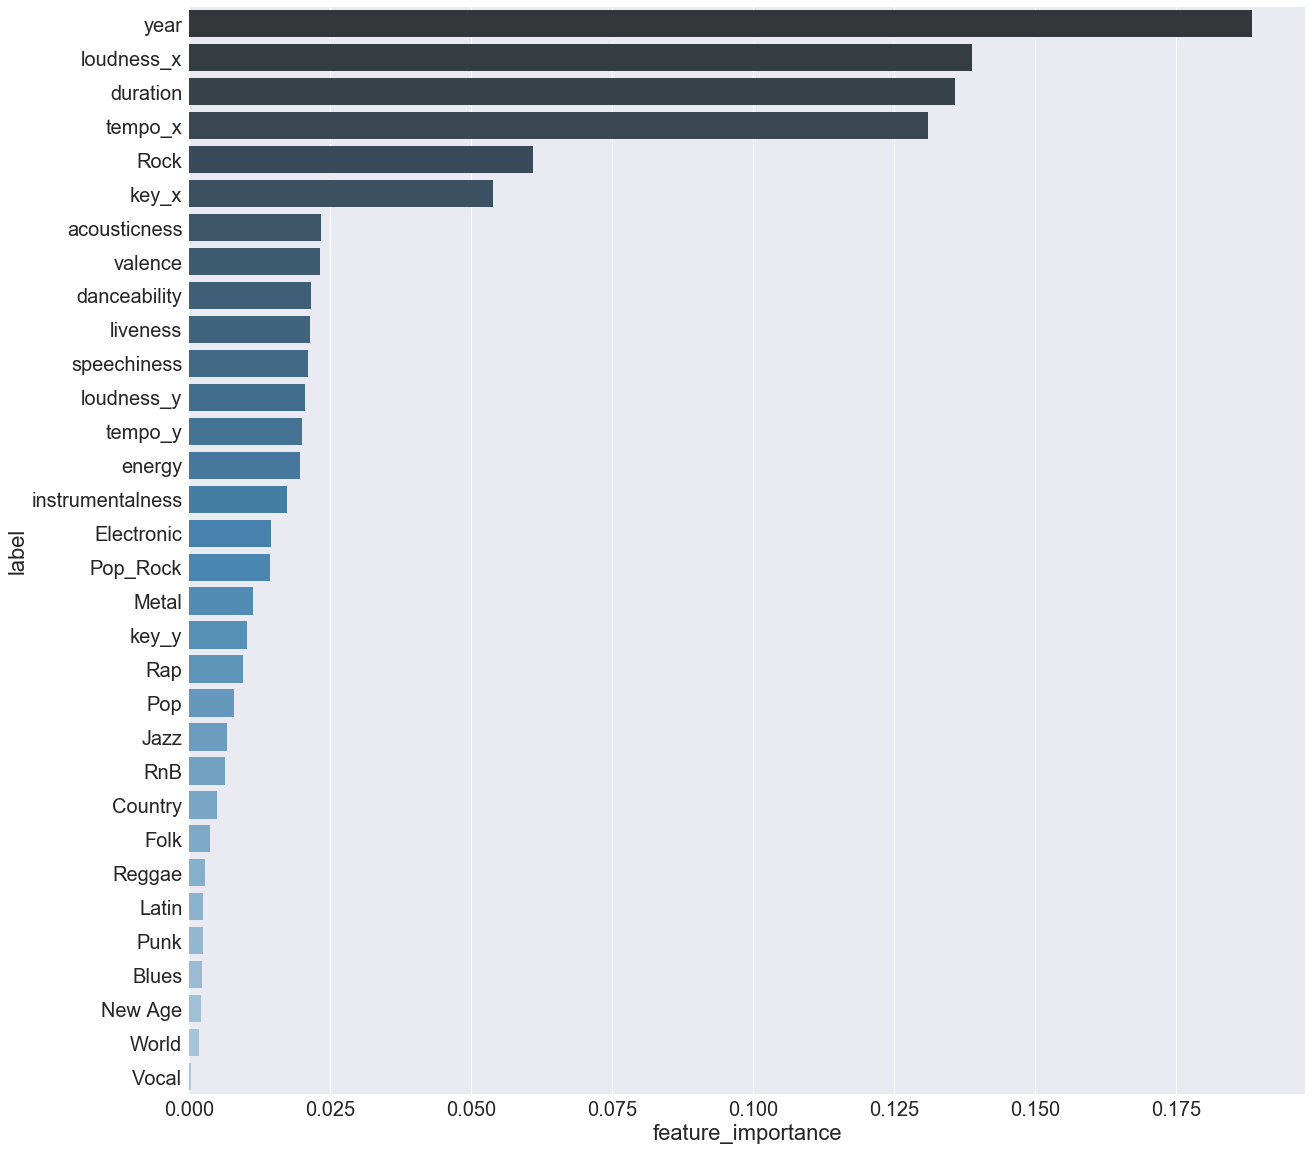

In [155]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,20))

snsplot = sns.barplot(x='feature_importance', y='label', data=feature_importance_df, palette="Blues_d", order=order)

snsplot.figure.savefig("../datastory/figures/RandomForest_feature_importance.png")

It looks like the year is quite important in comparison of the others feature. It make sense because the song_hotttnesss is in all likelihood decaying with time. As we will see later, a song is usually good at the time it was created, and it's really hard to extract songs that are good at all time. 

Thus it makes sense to do an analyze year per year (or decade per decade). Note that with this, it makes sense to do a deeper analyze of every genre, as a genre was trending at some point in time (let's thing of Rock in 70's, Electronic from 2000, ...).